# Libraries

In [1]:
from google.colab import drive

import gensim.downloader as api
import matplotlib.pyplot as plt
import numpy as np
import random
import statistics
import torch

In [2]:
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Experiments/model-scale-evaluation

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Experiments/model-scale-evaluation


In [3]:
from model import Model

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Evaluation Functions

In [5]:
from evaluation_functions import evaluate_analogies, evaluate_analogies_distance, evaluate_analogies_projected
from evaluation_functions import evaluate_similarity
from evaluation_functions import evaluate_word_sense, evaluate_word_sense_cos

# Get Models

## Our Models

In [6]:
model_names = ["data_12_5", "data_25", "data_50", "base"]
models = [torch.load("models/%s.torch" % m, map_location=device) for m in model_names]
models = [model.embedding_input_dictionary() for model in models]

versions = ["base (12.5%)", "base (25%)", "base (50%)", "base"]
with open('models/models.txt', 'r') as file:
    print(file.read())

base - Entire dataset
data_12_5 - 12.5% of the dataset
data_25 - 25% of the dataset
data_50 - 50% of the dataset


# Get Data

In [7]:
lines = open('data/google-analogy-test.txt', 'r').readlines()
analogies_test = [line.lower().strip().split() for line in lines[1:]] # First line invalid

print("Total analogies: %d" % (len(analogies_test)))

Total analogies: 19557


In [8]:
lines = open('data/wordsim_similarity_goldstandard.txt', 'r').readlines()
wordsim_similarity = [line.lower().strip().split() for line in lines]

print("Total pairs: %d" % (len(wordsim_similarity)))

Total pairs: 203


In [9]:
lines = open('data/wordsim_relatedness_goldstandard.txt', 'r').readlines()
wordsim_relatedness = [line.lower().strip().split() for line in lines]

print("Total pairs: %d" % (len(wordsim_relatedness)))

Total pairs: 252


In [10]:
lines = open('data/standford-rw-similarity.txt', 'r').readlines()
standford_rw = [line.lower().strip().split()[:3] for line in lines] # Take only first 3

print("Total pairs: %d" % (len(standford_rw)))

Total pairs: 2034


In [11]:
lines = open('data/rg65.txt', 'r').readlines()
rg65 = [line.lower().strip().split()[:3] for line in lines]

print("Total pairs: %d" % (len(rg65)))

Total pairs: 65


In [12]:
lines = open('data/simlex.txt', 'r').readlines()
simlex = [line.lower().strip().split()[:4] for line in lines[1:]]
simlex = [[x[0], x[1], x[3]] for x in simlex]

print("Total pairs: %d" % (len(simlex)))

Total pairs: 999


In [13]:
lines = open('data/gpt-dataset.txt', 'r').readlines()
gpt_dataset = [line.lower().strip().split(";") for line in lines]

print("Total examples: %d" % (len(gpt_dataset)))

Total examples: 100


# Evaluate Models

## Similarity

In [14]:
similarity_scores = dict()

In [15]:
for v, embeddings in enumerate(models):

  print("\n----- %s -----" % versions[v])

  score1 = evaluate_similarity(embeddings, wordsim_similarity)
  print("Wordsim Similarity Score: %.4f" % score1)

  score2 = evaluate_similarity(embeddings, wordsim_relatedness)
  print("Wordsim Relatedness Score: %.4f" % score2)

  score3 = evaluate_similarity(embeddings, wordsim_similarity + wordsim_relatedness)
  print("Wordsim Combined Score: %.4f" % score3)

  score4 = evaluate_similarity(embeddings, standford_rw)
  print("Standford RW Score: %.4f" % score4)

  score5 = evaluate_similarity(embeddings, rg65)
  print("RG65 Score: %.4f" % score5)

  score6 = evaluate_similarity(embeddings, simlex)
  print("Simlex Score: %.4f" % score6)

  score7 = statistics.mean([score1, score2, score3, score4, score5, score6])
  print("Average Score: %.4f" % score7)

  similarity_scores[v] = [score1, score2, score3, score4, score5, score6, score7]


----- base (12.5%) -----
Wordsim Similarity Score: 0.2904
Wordsim Relatedness Score: 0.3264
Wordsim Combined Score: 0.3114
Standford RW Score: 0.0396
RG65 Score: 0.2011
Simlex Score: 0.1102
Average Score: 0.2132

----- base (25%) -----
Wordsim Similarity Score: 0.5637
Wordsim Relatedness Score: 0.4745
Wordsim Combined Score: 0.5180
Standford RW Score: 0.1745
RG65 Score: 0.4643
Simlex Score: 0.1520
Average Score: 0.3912

----- base (50%) -----
Wordsim Similarity Score: 0.6072
Wordsim Relatedness Score: 0.5904
Wordsim Combined Score: 0.6021
Standford RW Score: 0.1895
RG65 Score: 0.4920
Simlex Score: 0.1661
Average Score: 0.4412

----- base -----
Wordsim Similarity Score: 0.6966
Wordsim Relatedness Score: 0.6228
Wordsim Combined Score: 0.6636
Standford RW Score: 0.2355
RG65 Score: 0.5733
Simlex Score: 0.2113
Average Score: 0.5005


## Analogy

In [16]:
analogy_scores = dict()

In [17]:
for v, embeddings in enumerate(models):

  print("\n----- %s -----" % versions[v])

  correlation1 = evaluate_analogies(embeddings, analogies_test)
  print("\rCorrelation (Cosine Based Evaluation): %.4f" % correlation1)

  correlation2 = evaluate_analogies_distance(embeddings, analogies_test)
  print("\rCorrelation (Euclidian Based Evaluation): %.4f" % correlation2)

  analogy_scores[v] = [correlation1, correlation2]


----- base (12.5%) -----
Correlation (Cosine Based Evaluation): 0.0090
Correlation (Euclidian Based Evaluation): 0.0080

----- base (25%) -----
Correlation (Cosine Based Evaluation): 0.0383
Correlation (Euclidian Based Evaluation): 0.0220

----- base (50%) -----
Correlation (Cosine Based Evaluation): 0.0528
Correlation (Euclidian Based Evaluation): 0.0145

----- base -----
Correlation (Cosine Based Evaluation): 0.1246
Correlation (Euclidian Based Evaluation): 0.0322


## Word Sense Distinction

In [18]:
sense_scores = dict()

In [19]:
for v, embeddings in enumerate(models):

  print("\n----- %s -----" % versions[v])

  positives1, negatives1 = evaluate_word_sense(embeddings, embeddings, gpt_dataset)
  score1 = negatives1 - positives1
  print("\nProjection-Based\nPositive Samples: %.3f\nNegative Samples: %.3f" % (positives1, negatives1))
  print("Score: %.4f" % (score1))

  positives2, negatives2 = evaluate_word_sense_cos(embeddings, embeddings, gpt_dataset)
  score2 = negatives2 - positives2
  print("\nCosine-Based\nPositive Samples: %.3f\nNegative Samples: %.3f" % (positives2, negatives2))
  print("Score: %.4f" % (score2))

  sense_scores[v] = [score1, score2]


----- base (12.5%) -----

Projection-Based
Positive Samples: 0.044
Negative Samples: 0.050
Score: 0.0055

Cosine-Based
Positive Samples: 0.044
Negative Samples: 0.050
Score: 0.0058

----- base (25%) -----

Projection-Based
Positive Samples: 0.039
Negative Samples: 0.061
Score: 0.0222

Cosine-Based
Positive Samples: 0.039
Negative Samples: 0.061
Score: 0.0220

----- base (50%) -----

Projection-Based
Positive Samples: 0.046
Negative Samples: 0.065
Score: 0.0192

Cosine-Based
Positive Samples: 0.048
Negative Samples: 0.065
Score: 0.0170

----- base -----

Projection-Based
Positive Samples: 0.053
Negative Samples: 0.070
Score: 0.0167

Cosine-Based
Positive Samples: 0.054
Negative Samples: 0.070
Score: 0.0158


# Visualizations

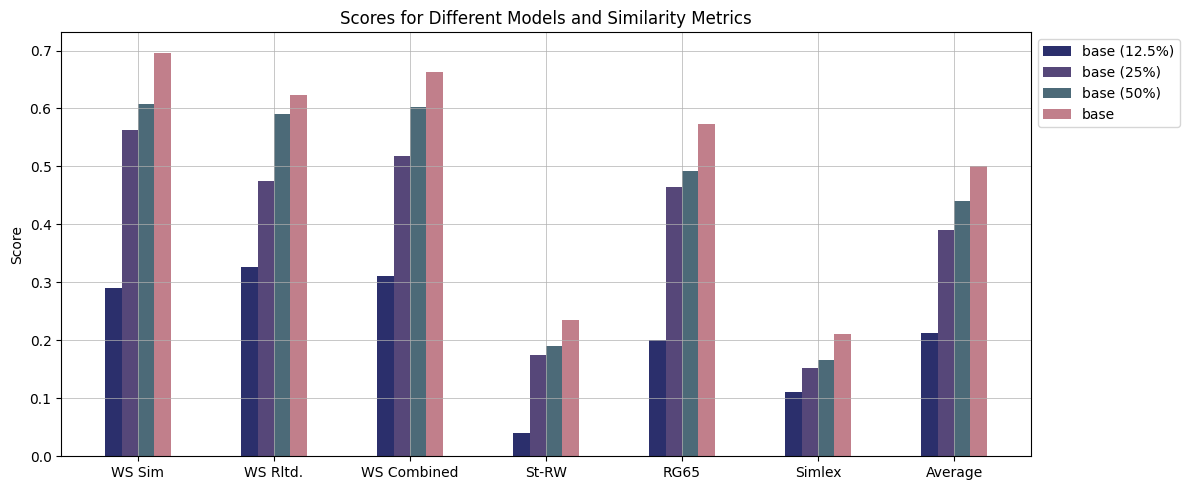

In [20]:
metrics = ['WS Sim', 'WS Rltd.', 'WS Combined', 'St-RW', 'RG65', 'Simlex', 'Average']
colors = ['#2B2F6C', '#564779', '#4C6A78', '#C17F8B', '#532200', '#22404A']

# Define the models and their respective scores
scores = list(similarity_scores.values())

bar_width = 0.12
x = np.arange(len(metrics))

fig, ax = plt.subplots(figsize=(12, 5))

for i, version in enumerate(versions):
    ax.bar(x + i * bar_width, [score for score in scores[i]], bar_width, label=version, color=colors[i])

ax.set_xticks(x + bar_width * (len(versions) - 1) / 2)
ax.set_xticklabels(metrics)

ax.set_ylabel('Score')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_title('Scores for Different Models and Similarity Metrics')

plt.tight_layout()
plt.grid("both", linewidth=0.5)
plt.show()

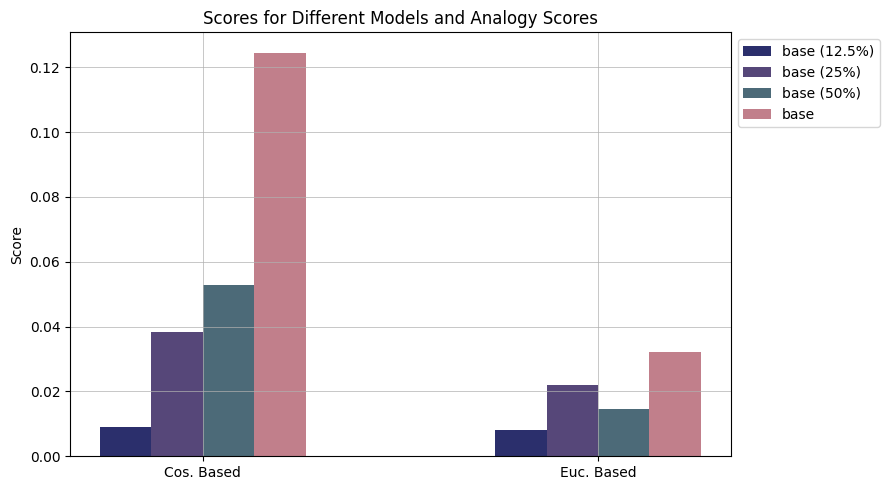

In [21]:
metrics = ['Cos. Based', 'Euc. Based']
colors = ['#2B2F6C', '#564779', '#4C6A78', '#C17F8B', '#532200', '#22404A']

# Define the models and their respective scores
scores = list(analogy_scores.values())

bar_width = 0.13
x = np.arange(len(metrics))

fig, ax = plt.subplots(figsize=(9, 5))

for i, version in enumerate(versions):
    ax.bar(x + i * bar_width, [score for score in scores[i]], bar_width, label=version, color=colors[i])

ax.set_xticks(x + bar_width * (len(versions) - 1) / 2)
ax.set_xticklabels(metrics)

ax.set_ylabel('Score')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_title('Scores for Different Models and Analogy Scores')

plt.tight_layout()
plt.grid("both", linewidth=0.5)
plt.show()

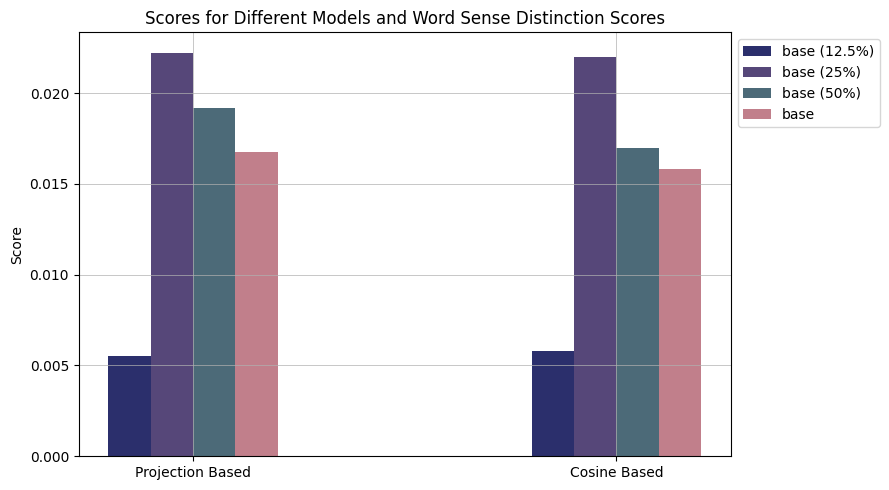

In [22]:
metrics = ["Projection Based", "Cosine Based"]
colors = ['#2B2F6C', '#564779', '#4C6A78', '#C17F8B', '#532200', '#22404A']

# Define the models and their respective scores
scores = list(sense_scores.values())

bar_width = 0.1
x = np.arange(len(metrics))

fig, ax = plt.subplots(figsize=(9, 5))

for i, version in enumerate(versions):
    ax.bar(x + i * bar_width, [score for score in scores[i]], bar_width, label=version, color=colors[i])

ax.set_xticks(x + bar_width * (len(versions) - 1) / 2)
ax.set_xticklabels(metrics)

ax.set_ylabel('Score')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_title('Scores for Different Models and Word Sense Distinction Scores')

plt.tight_layout()
plt.grid("both", linewidth=0.5)
plt.show()

# DC

In [ ]:
from google.colab import runtime
runtime.unassign()